### Feature Set Optimization  
  
Noticed an error in the hjorth feature set. I accidentally included the index number in the feature set because I didn't include index = None when I saved the data. So, that 82% accuracy was misleading and was actually supposed to be 67%. This changes things substantially and so I have to pivot and figure out how to optimize the feature set I move forward with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

In [4]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [5]:
activity_indexes = pd.read_csv('activity_indexes.csv')

In [6]:
index_lists = [activity_indexes[col] for col in activity_indexes.columns]

In [7]:
y = get_yvals(2000)['activity']

### Hjorth

In [14]:
pd.read_csv('time_mob_df.csv')

,Fp1_mob,F3_mob,C3_mob,P3_mob,F7_mob,T3_mob,T5_mob,O1_mob,Fz_mob,Cz_mob,Pz_mob,Fp2_mob,F4_mob,C4_mob,P4_mob,F8_mob,T4_mob,T6_mob,O2_mob
0,-0.367441,-0.278383,-0.243253,-0.317295,-0.374151,-0.575495,-0.418398,-0.185276,-0.361535,-0.088579,-0.356679,-0.704473,0.761959,-0.278402,1.968461,0.106754,1.770974,1.955715,1.929077
1,0.447961,0.726267,1.916895,1.043887,0.900723,1.081992,0.543349,0.380618,-0.227745,0.713309,0.021545,0.612303,1.664094,2.114387,-0.076350,1.491766,1.138853,0.040762,-0.192718
2,1.219120,2.031818,1.798271,1.708546,1.385946,0.719711,2.365792,2.107448,2.726686,2.109199,1.547099,0.968869,1.313103,0.770677,2.212054,1.965128,1.977089,1.556333,2.141574
3,2.667684,2.613964,2.548682,2.740367,2.592996,2.388708,2.618644,2.742782,2.727125,2.555201,2.582519,2.785106,2.443765,2.360773,2.288376,2.710600,2.349421,2.423066,2.651136
4,1.289071,1.540952,1.604811,1.530876,1.868812,1.402564,1.805593,1.171978,1.275797,1.367173,1.267182,1.014067,2.081767,1.851221,1.791243,1.982137,1.439543,1.883778,1.065130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.074940,1.496482,1.551885,0.134040,1.374984,1.901648,1.299964,-0.512726,-0.252298,-0.617336,0.354278,-0.455936,-0.607380,-0.516531,0.359003,-0.426564,0.071401,0.253528,-0.243446
11996,-0.783934,0.183871,0.539278,0.744960,-0.264596,-0.135132,-0.047998,2.536168,1.321656,0.702660,0.820958,-1.344672,-0.981588,-0.689922,-0.884973,-0.152536,2.298683,-0.275754,2.443156
11997,-0.108618,-0.485444,-0.341634,-0.452079,0.289439,0.752952,0.902293,-0.519688,-0.482433,-0.577200,0.241299,0.370701,-0.373174,-0.523952,-0.441816,-0.523496,-0.406206,0.204760,-0.049833
11998,1.566109,2.565272,2.261291,2.580553,2.788518,1.358582,1.598023,2.071184,1.389701,2.550031,2.231485,2.463707,2.166852,2.211613,2.309140,0.663297,0.828794,2.333832,2.543954


In [15]:
pd.read_csv('time_comp_df.csv')

,Fp1_comp,F3_comp,C3_comp,P3_comp,F7_comp,T3_comp,T5_comp,O1_comp,Fz_comp,Cz_comp,Pz_comp,Fp2_comp,F4_comp,C4_comp,P4_comp,F8_comp,T4_comp,T6_comp,O2_comp
0,3.509781,3.607084,3.432797,4.007033,4.336510,4.632141,3.743348,3.391817,3.862556,3.049918,4.149693,4.802277,1.893002,3.515063,1.196629,2.879536,1.212444,1.177139,1.216597
1,2.141492,1.998572,1.259053,1.837071,1.959071,1.663429,2.094091,2.378835,3.510302,1.901061,2.918943,2.026676,1.391733,1.128430,3.181490,1.560563,1.555554,2.712718,3.355168
2,1.557694,1.207964,1.244447,1.369160,1.540187,1.867801,1.078983,1.183831,1.008336,1.138777,1.378669,1.730360,1.530229,1.849235,1.116321,1.266899,1.145833,1.329318,1.144627
3,1.026434,1.018401,1.009937,1.019282,1.063701,1.041900,1.011127,1.001245,1.009251,1.011264,1.011976,1.014402,1.065718,1.055349,1.093746,1.026571,1.031013,1.038577,1.001191
4,1.581419,1.378845,1.289921,1.386554,1.286456,1.331115,1.249970,1.583761,1.493777,1.388239,1.487358,1.744979,1.210324,1.219566,1.269258,1.256098,1.298570,1.245705,1.638034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2.662224,1.489206,1.422643,3.062302,1.633587,1.275340,1.593122,5.045866,3.692739,5.731409,2.523754,3.927175,5.426112,4.866273,2.508772,4.846962,2.710758,2.462865,3.771992
11996,5.418714,2.623849,2.103334,2.033558,3.992611,3.156509,2.973133,1.053345,1.532854,1.925408,1.869559,12.542025,9.570026,5.618490,9.420340,3.562476,1.044593,3.390180,1.054748
11997,2.916269,3.796942,3.161027,3.947491,2.703492,1.938665,1.845211,4.398611,4.280429,4.072336,2.545876,2.267513,3.917795,4.596791,4.640288,5.304908,3.730205,2.394692,3.021624
11998,1.383420,1.030399,1.089604,1.060465,1.011726,1.429801,1.347993,1.194140,1.485894,1.011593,1.112639,1.093840,1.146263,1.097575,1.086426,2.085543,1.717572,1.062619,1.027760


In [16]:
pd.read_csv('spectral_mob_df.csv')

,Fp1_spect_mob,F3_spect_mob,C3_spect_mob,P3_spect_mob,F7_spect_mob,T3_spect_mob,T5_spect_mob,O1_spect_mob,Fz_spect_mob,Cz_spect_mob,Pz_spect_mob,Fp2_spect_mob,F4_spect_mob,C4_spect_mob,P4_spect_mob,F8_spect_mob,T4_spect_mob,T6_spect_mob,O2_spect_mob
0,-0.258883,-0.226042,-0.246400,-0.205438,-0.212759,-0.312176,-0.256910,-0.162625,-0.249756,-0.209600,-0.240023,-0.325922,0.247282,-0.221971,0.973655,-0.117761,0.542914,0.824642,0.541568
1,-0.082024,0.289943,3.084915,0.471426,0.038138,0.192166,-0.095680,-0.096901,-0.171951,0.101352,-0.162159,0.079498,1.298905,5.176606,-0.119612,0.618020,0.376029,-0.158386,-0.201692
2,0.104605,0.275991,-0.175024,-0.200168,0.027561,-0.206883,0.663355,-0.096401,5.464423,-0.160400,-0.153606,-0.105509,-0.254053,-0.227633,-0.076247,-0.000300,-0.148422,-0.171678,-0.112940
3,-0.050678,-0.021831,0.195774,0.056720,-0.019466,-0.126983,1.580645,13.233366,-0.035909,-0.073630,-0.046662,0.025449,-0.013394,-0.003049,0.095514,-0.004767,-0.058161,0.021068,12.418056
4,1.046644,0.490751,1.173815,0.702402,4.671495,3.087671,1.333416,0.300720,0.127644,0.182708,0.202626,0.779441,1.473852,1.772020,1.240120,6.520776,4.481444,2.504725,0.343245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.204247,1.538891,2.019589,-0.016342,2.425312,3.994396,1.616337,-0.199810,-0.158160,-0.263972,-0.168478,-0.178408,-0.230590,-0.262657,-0.191945,-0.192328,-0.262930,-0.223033,-0.210571
11996,-0.258912,0.114581,0.248606,0.259478,-0.136612,-0.148124,-0.074876,5.370519,0.841876,0.137564,0.097209,-0.393560,-0.281163,-0.231154,-0.278429,0.046970,4.611741,-0.138435,5.000345
11997,-0.093087,-0.266145,-0.245118,-0.222490,0.089748,0.404227,0.707501,-0.215861,-0.242347,-0.267608,-0.164325,0.476611,-0.232071,-0.282462,-0.249384,-0.220584,-0.254976,-0.117592,-0.187455
11998,1.363270,3.536572,1.354617,1.520372,13.203374,0.157559,0.331568,0.533850,-0.051996,9.266857,0.863959,1.054184,0.743638,0.843867,1.156162,-0.040585,0.017694,1.673418,2.587095


In [17]:
pd.read_csv('freq_comp_df.csv')

,Fp1_spect_comp,F3_spect_comp,C3_spect_comp,P3_spect_comp,F7_spect_comp,T3_spect_comp,T5_spect_comp,O1_spect_comp,Fz_spect_comp,Cz_spect_comp,Pz_spect_comp,Fp2_spect_comp,F4_spect_comp,C4_spect_comp,P4_spect_comp,F8_spect_comp,T4_spect_comp,T6_spect_comp,O2_spect_comp
0,4.455751e+05,2.790305e+05,1.985222e+05,1.776044e+05,3.143707e+05,2.362627e+05,2.478484e+05,3.702049e+05,1.311942e+05,2.951828e+05,2.110316e+05,1.903197e+05,1.579171e+06,3.020601e+05,3.630917e+06,5.738094e+05,3.355065e+06,3.695199e+06,3.352718e+06
1,9.236638e+05,2.604607e+06,1.143503e+07,2.622868e+06,1.448780e+06,2.620133e+06,9.170206e+05,7.426686e+05,4.859470e+05,1.687511e+06,5.618003e+05,1.345234e+06,6.540810e+06,1.379361e+07,6.771064e+05,3.794406e+06,3.763305e+06,8.393007e+05,3.955650e+05
2,1.282149e+06,2.375595e+06,4.276941e+05,2.041802e+05,1.158974e+06,6.067844e+05,3.011442e+06,6.400930e+05,1.977203e+07,5.025623e+05,5.516167e+05,7.328629e+05,2.643820e+05,3.769042e+05,6.705267e+05,1.048130e+06,8.703531e+05,5.997128e+05,7.005669e+05
3,8.790402e+05,8.902731e+05,1.232476e+06,8.291605e+05,8.285753e+05,8.203792e+05,5.707228e+06,5.170592e+07,8.786055e+05,8.430741e+05,9.644950e+05,1.013683e+06,8.714000e+05,8.514414e+05,1.152746e+06,8.668231e+05,1.162254e+06,1.198891e+06,5.179775e+07
4,5.103247e+06,3.190175e+06,4.254180e+06,2.803286e+06,1.717113e+07,1.250761e+07,6.334017e+06,2.523635e+06,1.743917e+06,2.221741e+06,2.379368e+06,3.705326e+06,7.234383e+06,6.922355e+06,5.847533e+06,2.408861e+07,2.165976e+07,1.284175e+07,3.161917e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1.741190e+06,8.853319e+06,8.451934e+06,9.825036e+05,1.159431e+07,2.165869e+07,9.232627e+06,3.349473e+05,6.003071e+05,1.457807e+05,7.779998e+05,6.638837e+05,4.114156e+05,3.186156e+05,5.330739e+05,5.558546e+05,6.275403e+05,6.892206e+05,4.440271e+05
11996,3.734831e+05,1.280666e+06,1.343554e+06,1.311818e+06,5.081188e+05,7.434621e+05,7.966328e+05,2.142647e+07,3.883944e+06,1.671880e+06,1.505237e+06,2.513059e+04,1.189116e+05,2.585148e+05,8.183365e+04,9.804821e+05,1.819993e+07,6.940248e+05,2.139840e+07
11997,8.392949e+05,1.689163e+05,1.635740e+05,1.096312e+05,1.680398e+06,3.807357e+06,4.743333e+06,1.885776e+05,2.063687e+05,7.499259e+04,5.229478e+05,2.603540e+06,3.725056e+05,2.174618e+05,2.489852e+05,4.827140e+05,5.852293e+05,1.080002e+06,4.335703e+05
11998,4.358056e+06,1.145577e+07,3.890675e+06,4.384676e+06,3.557356e+07,1.685270e+06,1.994917e+06,3.021902e+06,8.275624e+05,3.755362e+07,4.450565e+06,3.403477e+06,2.942173e+06,2.958491e+06,4.149494e+06,7.672818e+05,1.426321e+06,6.331198e+06,1.165264e+07


In [10]:
X1 = pd.read_csv('time_mob_df.csv')
X2 = pd.read_csv('spectral_mob_df.csv')
X3 = pd.read_csv('time_comp_df.csv')
X4 = pd.read_csv('freq_comp_df.csv')

xlist = [X1, X2, X3, X4]

X_hjorth = pd.DataFrame()

for x in xlist:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    X_hjorth = pd.concat([X_hjorth, x], axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_hjorth, y, test_size = 0.1, random_state = 42)

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Freq Bands and Hjorth Training')
print(classification_report(y_train, training_yhat))
print('Freq Bands and Hjorth Testing')
print(classification_report(y_test, testing_yhat))
train_acc1 = accuracy_score(y_train, training_yhat).round(decimals = 3)
test_acc1 = accuracy_score(y_test, testing_yhat).round(decimals = 3)
prec1 = precision_score(y_test, testing_yhat, average = None)
rec1 = recall_score(y_test, testing_yhat, average = None)
f1score1 = f1_score(y_test, testing_yhat, average = None)

Freq Bands and Hjorth Training
              precision    recall  f1-score   support

         GPD       0.77      0.92      0.84      1794
        GRDA       0.82      0.83      0.83      1819
         LPD       0.77      0.87      0.82      1800
        LRDA       0.83      0.87      0.85      1795
       Other       0.80      0.59      0.68      1808
     Seizure       0.80      0.72      0.75      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Freq Bands and Hjorth Testing
              precision    recall  f1-score   support

         GPD       0.71      0.85      0.77       206
        GRDA       0.63      0.72      0.67       181
         LPD       0.64      0.71      0.67       200
        LRDA       0.74      0.77      0.76       205
       Other       0.57      0.38      0.46       192
     Seizure       0.70      0.59      0.64       216

    accuracy    

In [13]:
train_acc1, test_acc1

(0.797, 0.672)

### Hjorth Altogether with Band Power

In [18]:
X1 = pd.read_csv('band_pow_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
X3 = pd.read_csv('spectral_mob_df.csv')
X4 = pd.read_csv('time_comp_df.csv')
X5 = pd.read_csv('freq_comp_df.csv')

xlist = [X1, X2, X3, X4, X5]

full_set = pd.DataFrame()

for x in xlist:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    full_set = pd.concat([full_set, x], axis = 1)

In [19]:
X = full_set.copy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Freq Bands and Hjorth Training')
print(classification_report(y_train, training_yhat))
print('Freq Bands and Hjorth Testing')
print(classification_report(y_test, testing_yhat))
acc1 = accuracy_score(y_test, testing_yhat)
prec1 = precision_score(y_test, testing_yhat, average = None)
rec1 = recall_score(y_test, testing_yhat, average = None)
f1score1 = f1_score(y_test, testing_yhat, average = None)

Freq Bands and Hjorth Training
              precision    recall  f1-score   support

         GPD       0.82      0.94      0.88      1794
        GRDA       0.81      0.88      0.84      1819
         LPD       0.77      0.90      0.83      1800
        LRDA       0.85      0.90      0.87      1795
       Other       0.81      0.62      0.70      1808
     Seizure       0.90      0.70      0.79      1784

    accuracy                           0.82     10800
   macro avg       0.83      0.82      0.82     10800
weighted avg       0.83      0.82      0.82     10800

Freq Bands and Hjorth Testing
              precision    recall  f1-score   support

         GPD       0.78      0.89      0.83       206
        GRDA       0.66      0.76      0.70       181
         LPD       0.67      0.81      0.73       200
        LRDA       0.77      0.82      0.80       205
       Other       0.60      0.47      0.53       192
     Seizure       0.84      0.57      0.68       216

    accuracy    

In [22]:
trainacc1 = accuracy_score(y_train, training_yhat)
testacc1 = accuracy_score(y_test, testing_yhat)

In [12]:
n_vals = [i for i in range(3, 11)]
train_accs, test_accs = [], []
for n in n_vals:
    knn = KNeighborsClassifier(n_neighbors = n, weights = 'uniform')
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [13]:
pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
             columns = ['{}'.format(str(n)) for n in n_vals]).transpose()

,Training,Testing
3,0.884444,0.755833
4,0.842037,0.734167
5,0.823056,0.720833
6,0.793796,0.705833
7,0.775185,0.697500
8,0.758704,0.685000
9,0.748611,0.680000
10,0.737037,0.663333


In [14]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Freq Bands and Hjorth Training')
print(classification_report(y_train, training_yhat))
print('Freq Bands and Hjorth Testing')
print(classification_report(y_test, testing_yhat))

Freq Bands and Hjorth Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.93      0.89      1819
         LPD       0.85      0.94      0.89      1800
        LRDA       0.92      0.95      0.93      1795
       Other       0.91      0.72      0.80      1808
     Seizure       0.94      0.81      0.87      1784

    accuracy                           0.88     10800
   macro avg       0.89      0.88      0.88     10800
weighted avg       0.89      0.88      0.88     10800

Freq Bands and Hjorth Testing
              precision    recall  f1-score   support

         GPD       0.77      0.91      0.83       206
        GRDA       0.70      0.85      0.77       181
         LPD       0.70      0.84      0.77       200
        LRDA       0.83      0.86      0.85       205
       Other       0.69      0.46      0.55       192
     Seizure       0.84      0.62      0.71       216

    accuracy    

In [16]:
trainacc2 = accuracy_score(y_train, training_yhat)
testacc2 = accuracy_score(y_test, testing_yhat)

In [24]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components = 40)
pca_df = pca.fit_transform(X)
evr = pca.explained_variance_ratio_

In [22]:
rsum = 0
by_component = []
for r in evr:
    rsum += r
    by_component.append(rsum)

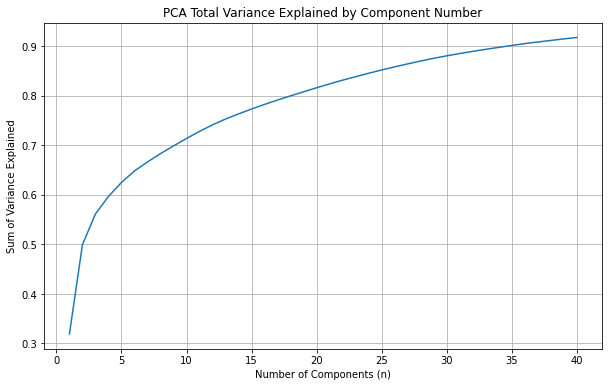

In [23]:
n_range = range(1, 41)
plt.figure(figsize = (10, 6))
plt.plot(n_range, by_component)
plt.title('PCA Total Variance Explained by Component Number')
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

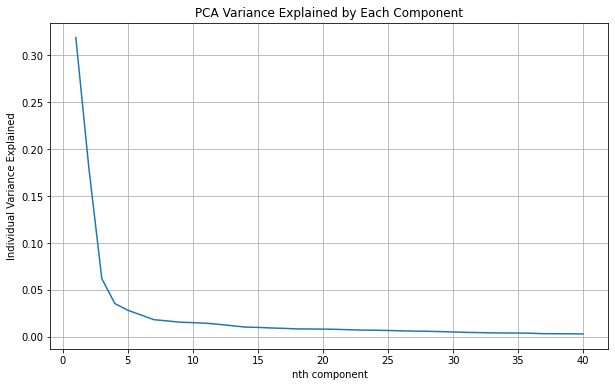

In [24]:
n_range = range(1, 41)
plt.figure(figsize = (10, 6))
plt.plot(n_range, evr)
plt.title('PCA Variance Explained by Each Component')
plt.xlabel('nth component')
plt.ylabel('Individual Variance Explained')
plt.grid(True)
plt.show()

In [25]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)
evr_total = pca.explained_variance_ratio_.sum()

In [26]:
evr_total.round(decimals = 3)

0.918

In [41]:
n_range = range(7, 41)
train_accs, test_accs = [], []
for n in n_range:
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

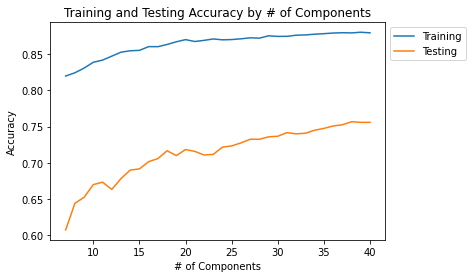

In [44]:
plt.plot(n_range, train_accs, label = 'Training')
plt.plot(n_range, test_accs, label = 'Testing')
plt.xlabel('# of Components')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy by # of Components')
plt.legend(bbox_to_anchor = [1, 1], loc = 'upper left')
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('PCA Set Training')
print(classification_report(y_train, training_yhat))
print('PCA Set Testing')
print(classification_report(y_test, testing_yhat))
acc1 = accuracy_score(y_test, testing_yhat)
prec1 = precision_score(y_test, testing_yhat, average = None)
rec1 = recall_score(y_test, testing_yhat, average = None)
f1score1 = f1_score(y_test, testing_yhat, average = None)

PCA Set Training
              precision    recall  f1-score   support

         GPD       0.83      0.94      0.88      1794
        GRDA       0.80      0.87      0.83      1819
         LPD       0.76      0.90      0.82      1800
        LRDA       0.84      0.89      0.86      1795
       Other       0.82      0.60      0.69      1808
     Seizure       0.87      0.71      0.78      1784

    accuracy                           0.82     10800
   macro avg       0.82      0.82      0.81     10800
weighted avg       0.82      0.82      0.81     10800

PCA Set Testing
              precision    recall  f1-score   support

         GPD       0.78      0.88      0.83       206
        GRDA       0.65      0.78      0.71       181
         LPD       0.70      0.81      0.75       200
        LRDA       0.75      0.80      0.78       205
       Other       0.59      0.45      0.51       192
     Seizure       0.79      0.56      0.66       216

    accuracy                           0.71 

In [148]:
n_vals = [i for i in range(3, 11)]
train_accs, test_accs = [], []
for n in n_vals:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [149]:
pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
             columns = ['{}'.format(str(n)) for n in n_vals]).transpose()

,Training,Testing
3,0.879907,0.752500
4,0.838148,0.724167
5,0.817963,0.710833
6,0.792778,0.697500
7,0.778611,0.691667
8,0.757963,0.680000
9,0.749167,0.673333
10,0.734074,0.660000


In [41]:
n_vals = [i * 2 for i in range(10, 21)]
train_accs, test_accs = [], []
for n in n_vals:
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [42]:
pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
            columns = ['{} Components'.format(n) for n in n_vals]).transpose()

,Training,Testing
20 Components,0.801481,0.681667
22 Components,0.805370,0.682500
24 Components,0.808889,0.692500
26 Components,0.812500,0.700833
28 Components,0.811852,0.698333
30 Components,0.812130,0.700000
32 Components,0.812870,0.700833
34 Components,0.816296,0.695833
36 Components,0.816204,0.709167
38 Components,0.817500,0.712500


In [74]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)
train_accs, test_accs = [], []
for n in range(3, 11):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    training_yhat = knn.predict(X_train)
    testing_yhat = knn.predict(X_test)
    train_accs.append(accuracy_score(y_train, training_yhat))
    test_accs.append(accuracy_score(y_test, testing_yhat))

In [75]:
pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'],
            columns = ['{} Neighbors'.format(i) for i in range(3, 11)]).transpose()

,Training,Testing
3 Neighbors,0.880370,0.753333
4 Neighbors,0.837407,0.723333
5 Neighbors,0.817593,0.711667
6 Neighbors,0.792500,0.692500
7 Neighbors,0.777685,0.686667
8 Neighbors,0.758981,0.680833
9 Neighbors,0.747500,0.672500
10 Neighbors,0.733241,0.660000


In [45]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))
confusion_matrices = multilabel_confusion_matrix(y_test, testing_yhat)
test_precs = precision_score(y_test, testing_yhat, average = None)
test_recs = recall_score(y_test, testing_yhat, average = None)
labels = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.92      0.89      1819
         LPD       0.84      0.93      0.88      1800
        LRDA       0.91      0.94      0.93      1795
       Other       0.91      0.71      0.80      1808
     Seizure       0.93      0.81      0.86      1784

    accuracy                           0.88     10800
   macro avg       0.88      0.88      0.88     10800
weighted avg       0.88      0.88      0.88     10800

Testing
              precision    recall  f1-score   support

         GPD       0.79      0.91      0.85       206
        GRDA       0.68      0.84      0.75       181
         LPD       0.72      0.82      0.77       200
        LRDA       0.82      0.83      0.82       205
       Other       0.66      0.44      0.53       192
     Seizure       0.81      0.66      0.73       216

    accuracy                           0.75      1200
   mac

In [55]:
f1_scores = f1_score(y_test, testing_yhat, average = None)

knn_scores = pd.DataFrame([test_precs, test_recs, f1_scores],
                         index = ['KNN_Precision', 'KNN_Recall', 'KNN_F1'],
                          columns = labels).transpose().round(decimals = 3)

In [56]:
knn_scores

,KNN_Precision,KNN_Recall,KNN_F1
GPD,0.792,0.908,0.846
GRDA,0.679,0.840,0.751
LPD,0.724,0.825,0.771
LRDA,0.817,0.829,0.823
Other,0.659,0.443,0.530
Seizure,0.811,0.657,0.726


In [32]:
trainacc3 = accuracy_score(y_train, training_yhat)
testacc3 = accuracy_score(y_test, testing_yhat)

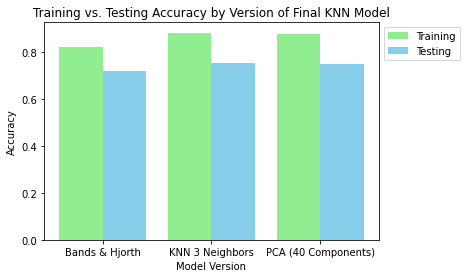

In [36]:
models = ['Bands & Hjorth', 'KNN 3 Neighbors', 'PCA (40 Components)']

X_axis = np.arange(len(models))

train_accs = [trainacc1, trainacc2, trainacc3]
test_accs = [testacc1, testacc2, testacc3]

plt.bar(X_axis - 0.2, train_accs, 0.4, label = 'Training', color = 'lightgreen') 
plt.bar(X_axis + 0.2, test_accs, 0.4, label = 'Testing', color = 'skyblue') 
  
plt.xticks(X_axis, models)
plt.xlabel('Model Version') 
plt.ylabel('Accuracy') 
plt.title('Training vs. Testing Accuracy by Version of Final KNN Model')
plt.legend(bbox_to_anchor = [1, 1], loc = 'upper left')
plt.show()

In [39]:
knn_results = pd.DataFrame([train_accs, test_accs], index = ['Training', 'Testing'], columns = models).transpose()

In [40]:
knn_results.round(decimals = 3)

,Training,Testing
Bands & Hjorth,0.823,0.721
KNN 3 Neighbors,0.884,0.756
PCA (40 Components),0.880,0.752


In [30]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

##### Confusion Matrices  
  
**Top Left:** True Negatives  
**Top Right:** False Positives  
**Bottom Left:** False Negatives  
**Bottom Right:** True Positives

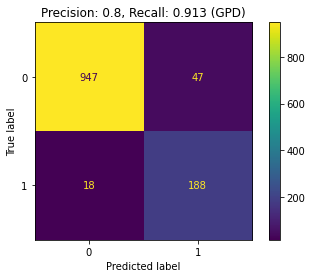

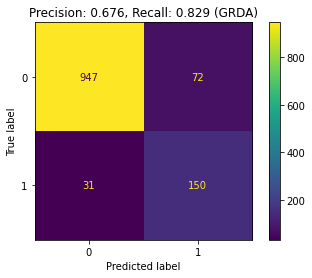

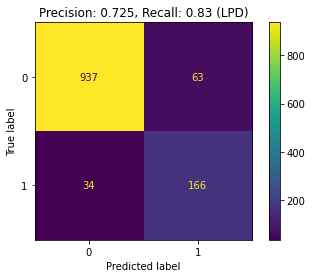

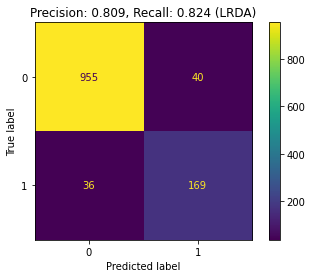

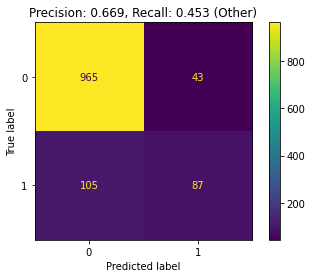

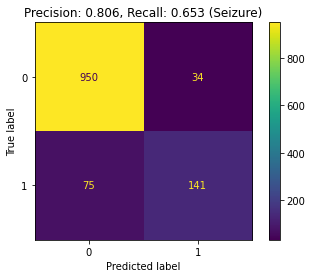

In [81]:
for i in range(confusion_matrices.shape[0]):
    disp = ConfusionMatrixDisplay(confusion_matrices[i])
    disp.plot()
    plt.title('Precision: {}, Recall: {} ({})'.format(test_precs[i].round(decimals = 3),
                                                      test_recs[i].round(decimals = 3), labels[i]))
    plt.show()

### Attempting LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [37]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_train = lda.transform(X_train)
lda_test = lda.transform(X_test)

In [41]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(lda_train, y_train)
training_yhat = knn.predict(lda_train)
testing_yhat = knn.predict(lda_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))
confusion_matrices = multilabel_confusion_matrix(y_test, testing_yhat)
test_precs = precision_score(y_test, testing_yhat, average = None)
test_recs = recall_score(y_test, testing_yhat, average = None)
labels = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

Training
              precision    recall  f1-score   support

         GPD       0.73      0.92      0.82      1794
        GRDA       0.64      0.83      0.72      1819
         LPD       0.70      0.74      0.72      1800
        LRDA       0.79      0.75      0.77      1795
       Other       0.80      0.55      0.65      1808
     Seizure       0.84      0.63      0.72      1784

    accuracy                           0.74     10800
   macro avg       0.75      0.74      0.73     10800
weighted avg       0.75      0.74      0.73     10800

Testing
              precision    recall  f1-score   support

         GPD       0.61      0.77      0.68       206
        GRDA       0.40      0.58      0.48       181
         LPD       0.49      0.57      0.53       200
        LRDA       0.61      0.55      0.58       205
       Other       0.45      0.30      0.36       192
     Seizure       0.62      0.38      0.47       216

    accuracy                           0.53      1200
   mac

### Changing LDA Solver (Eigen)  
  
**Shrinkage None**

In [46]:
lda = LinearDiscriminantAnalysis(solver = 'eigen')
lda.fit(X_train, y_train)
lda_train = lda.transform(X_train)
lda_test = lda.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(lda_train, y_train)
training_yhat = knn.predict(lda_train)
testing_yhat = knn.predict(lda_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))
confusion_matrices = multilabel_confusion_matrix(y_test, testing_yhat)
test_precs = precision_score(y_test, testing_yhat, average = None)
test_recs = recall_score(y_test, testing_yhat, average = None)
labels = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

Training
              precision    recall  f1-score   support

         GPD       0.73      0.92      0.82      1794
        GRDA       0.64      0.83      0.72      1819
         LPD       0.70      0.74      0.72      1800
        LRDA       0.79      0.75      0.77      1795
       Other       0.80      0.55      0.65      1808
     Seizure       0.84      0.63      0.72      1784

    accuracy                           0.74     10800
   macro avg       0.75      0.74      0.73     10800
weighted avg       0.75      0.74      0.73     10800

Testing
              precision    recall  f1-score   support

         GPD       0.61      0.77      0.68       206
        GRDA       0.40      0.58      0.48       181
         LPD       0.49      0.57      0.53       200
        LRDA       0.61      0.55      0.58       205
       Other       0.45      0.30      0.36       192
     Seizure       0.62      0.38      0.47       216

    accuracy                           0.53      1200
   mac

**Shrinkage Auto**

In [47]:
lda = LinearDiscriminantAnalysis(solver = 'eigen', shrinkage = 'auto')
lda.fit(X_train, y_train)
lda_train = lda.transform(X_train)
lda_test = lda.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(lda_train, y_train)
training_yhat = knn.predict(lda_train)
testing_yhat = knn.predict(lda_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))
confusion_matrices = multilabel_confusion_matrix(y_test, testing_yhat)
test_precs = precision_score(y_test, testing_yhat, average = None)
test_recs = recall_score(y_test, testing_yhat, average = None)
labels = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

Training
              precision    recall  f1-score   support

         GPD       0.75      0.94      0.84      1794
        GRDA       0.70      0.85      0.77      1819
         LPD       0.73      0.79      0.76      1800
        LRDA       0.82      0.81      0.82      1795
       Other       0.83      0.57      0.68      1808
     Seizure       0.85      0.65      0.74      1784

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.77     10800
weighted avg       0.78      0.77      0.77     10800

Testing
              precision    recall  f1-score   support

         GPD       0.68      0.77      0.72       206
        GRDA       0.48      0.65      0.55       181
         LPD       0.57      0.64      0.60       200
        LRDA       0.64      0.67      0.65       205
       Other       0.48      0.31      0.38       192
     Seizure       0.58      0.44      0.50       216

    accuracy                           0.58      1200
   mac

### Back to PCA and Attempting Different Models

In [52]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Altogether Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Altogether Testing')
print(classification_report(y_test, testing_yhat))
hjorth_acc = accuracy_score(y_test, testing_yhat)
hjorth_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_f1 = f1_score(y_test, testing_yhat, average = None)
hjorth_prec = precision_score(y_test, testing_yhat, average = None)
hjorth_rec = recall_score(y_test, testing_yhat, average = None)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.92      0.89      1819
         LPD       0.84      0.93      0.88      1800
        LRDA       0.91      0.94      0.93      1795
       Other       0.91      0.71      0.80      1808
     Seizure       0.93      0.81      0.87      1784

    accuracy                           0.88     10800
   macro avg       0.88      0.88      0.88     10800
weighted avg       0.88      0.88      0.88     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.79      0.91      0.85       206
        GRDA       0.68      0.84      0.75       181
         LPD       0.73      0.83      0.78       200
        LRDA       0.81      0.82      0.82       205
       Other       0.66      0.45      0.53       192
     Seizure       0.82      0.66      0.73       216

    accuracy            

### XGBoost

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)
training_yhat = xgb.predict(X_train)
testing_yhat = xgb.predict(X_test)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.81      0.85      0.83      1794
        GRDA       0.68      0.77      0.72      1819
         LPD       0.67      0.76      0.71      1800
        LRDA       0.75      0.70      0.73      1795
       Other       0.67      0.54      0.60      1808
     Seizure       0.71      0.69      0.70      1784

    accuracy                           0.72     10800
   macro avg       0.72      0.72      0.72     10800
weighted avg       0.72      0.72      0.72     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.78      0.76      0.77       206
        GRDA       0.54      0.63      0.58       181
         LPD       0.59      0.66      0.62       200
        LRDA       0.68      0.59      0.63       205
       Other       0.48      0.44      0.46       192
     Seizure       0.61      0.59      0.60       216

    accuracy            

In [54]:
print('XGBoost Training')
print(classification_report(y_train, training_yhat))
print('XGBoost Testing')
print(classification_report(y_test, testing_yhat))

XGBoost Training
              precision    recall  f1-score   support

         GPD       0.81      0.85      0.83      1794
        GRDA       0.68      0.77      0.72      1819
         LPD       0.67      0.76      0.71      1800
        LRDA       0.75      0.70      0.73      1795
       Other       0.67      0.54      0.60      1808
     Seizure       0.71      0.69      0.70      1784

    accuracy                           0.72     10800
   macro avg       0.72      0.72      0.72     10800
weighted avg       0.72      0.72      0.72     10800

XGBoost Testing
              precision    recall  f1-score   support

         GPD       0.78      0.76      0.77       206
        GRDA       0.54      0.63      0.58       181
         LPD       0.59      0.66      0.62       200
        LRDA       0.68      0.59      0.63       205
       Other       0.48      0.44      0.46       192
     Seizure       0.61      0.59      0.60       216

    accuracy                           0.61 

### One vs. Rest LinearSVC

In [55]:
from sklearn.svm import LinearSVC

In [56]:
svc = LinearSVC()
svc.fit(X_train, y_train)
training_yhat = svc.predict(X_train)
testing_yhat = svc.predict(X_test)
print('LinearSVC Training')
print(classification_report(y_train, training_yhat))
print('LinearSVC Testing')
print(classification_report(y_test, testing_yhat))

/home/clay/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Training
              precision    recall  f1-score   support

         GPD       0.58      0.75      0.65      1794
        GRDA       0.40      0.54      0.46      1819
         LPD       0.46      0.40      0.43      1800
        LRDA       0.43      0.41      0.42      1795
       Other       0.40      0.23      0.30      1808
     Seizure       0.50      0.47      0.48      1784

    accuracy                           0.47     10800
   macro avg       0.46      0.47      0.46     10800
weighted avg       0.46      0.47      0.46     10800

LinearSVC Testing
              precision    recall  f1-score   support

         GPD       0.62      0.77      0.68       206
        GRDA       0.38      0.56      0.45       181
         LPD       0.50      0.44      0.47       200
        LRDA       0.45      0.39      0.42       205
       Other       0.33      0.21      0.26       192
     Seizure       0.49      0.45      0.47       216

    accuracy                           0